### ASTR-598, University of Washington

# Week 7.1: Principal Component Analysis

##### Bibliography:
- Textbook Chapter 7.1, 7.2, 7.3
- [Alex Williams: Everything you did and didn't know about PCA](http://alexhwilliams.info/itsneuronalblog/2016/03/27/pca/)
- [Jake VanderPlas: In Depth: Principal Component Analysis](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html)

## The Curse of Dimensionality

Let's say I want to buy a new laptop, and my criteria include (1) price, (2) weight, (3) screen size, (4) memory, and (5) disk space. If I gave laptops a low, medium, or high grade on each of these five **features**, then there are $3^5=243$ possible combinations of grades. If I want to feel like I've done a thorough search, I'll want to look at at least one laptop with each combination of grades, but that's a lot. Alternatively, if I pick a grade I want for each feature, then only $3^{-5} = 0.4\%$ of laptops will meet my criteria. If I add more criteria, both of these numbers will get exponentially worse.

But laptops are not uniformly distributed in the 5-dimensional space described by my criteria. Let's say I find two important patterns:
- laptops with larger screens tend to be heavier
- more expensive laptops tend to have more memory and disk space

Then I really only need to consider two criteria: (1) do I want a big, heavy laptop, or a small, light one and (2) do I want an expensive, high-performance laptop or a cheaper budget model?

Grading laptops on these 2 criteria gives me $3^2 = 9$ possible combinations, a much more managable number. I have just done **dimensionality reduction** and found that the **intrinsic dimensionality** of laptop specs is 2.

Now imagine we've done an astronomical survey where we've measured hundreds of things about millions of objects. Dimensionality reduction helps us understand the the patterns in the data we've collected. We want to find how our hundreds of measurements can be described by a few different populations of objects which have a few underlying physical parameters.

## Principal Component Analysis

Let's say this is a scatter plot of laptop weight vs screen size:

![scatter plot with PCA basis](figures/PCAscatter.png)

There is a strong correlation between these two features that we'd like to describe. Instead of considering laptop weight and screen size separately, let's say I want to find the linear combination of the two features that best describes the data.

PCA does this by finding a new *basis* where the first basis vector is in the direction of maximum variance. This is equivalent to minimizing the sum of squared distances between data points and their projections onto the first basis vector:

![scatter plot with PCA projection](figures/PCAprojection.png)

Let's look a bit at the mathematics of how PCA works. Let's say we have $N$ data points with $K$ features each, described by the $N\times K$ matrix $X$ where $X_{ij}$ is the $j^{\rm th}$ feature of the $i^{\rm th}$ data point, and that we've subtracted the mean value of each feature out. Consider the covariance matrix of the data:

$$C_X = \frac{1}{N-1} X^{T} X$$

The diagonal elements of the covariance matrix are the variance of the data for each feature (recall that the mean of each feature is now zero):

$$[C_X]_{jj} = \frac{1}{N-1} \sum_i [X^T]_{ji} X_{ij} = \frac{1}{N-1} \sum_i X_{ij} X_{ij} = \frac{1}{N-1} \sum_i X_{ij}^2$$

The sum of the diagonal elements of the covariance matrix is often called the **total variance**: you can think of it as adding together the variance of the data for all features. It turns out to be proportional to the sum of squared distances between each data point $X_i$ and the origin:

$${\rm total \, variance} = \sum_j [C_X]_{jj} = \frac{1}{N-1} \sum_j \sum_i X_{ij}^2 = \frac{1}{N-1} \sum_i \lVert X_i \rVert^2$$

Now we want to find the first PCA basis vector $r_1$ that is in the direction of maximum variance. Projecting all of the data onto $r_1$ would yield one number $Y_i$ for every data point:

$$Y_i = \sum_j X_{ij} [r_1]_j \Rightarrow Y = X r_1$$

Maximizing the variance means maximizing the sum of squares of this projection:

$$\sum_i Y_i^2 = Y^T Y = (X r_1)^T X r_1 = r_1^T X^T X r_1 = (N-1) r_1^T C_X r_1$$

It turns out that maximizing the variance while keeping the length of $r_1$ equal to 1 means that $r_1$ is the *eigenvector* of $C_X$ with the largest *eigenvalue* (the first principal component). The other eigenvectors, in decreasing order by their eigenvalues are the remaining principal components. So we can reduce the dimensionality of $X$ by projecting it onto the first few principal components.

Why is maximizing the variance of the projection equivalent to minimizing the sum of squared distances between the data and their projections? The squared distance of a data point to the origin is its contribution to the total variance: the sum of the diagonal elements of $C_X = X^T X$. The squared length of a data point's projection is its contribution to the remaining variance after projection, $Y^T Y$. By the Pythagorean theorem, the difference between these two is the squared distance between the data point and its projection (or the data point's contribution to the lost variance). Thus, maximizing the variance of the projection is equivalent to mimimizing the sum of squared distances between the data points and their projections.

![PCA variance and MSE](figures/PCAvariance.png)
(from [Alex William's blog post](http://alexhwilliams.info/itsneuronalblog/2016/03/27/pca/))

Why is this interesting? Let's say we modeled the data $X$ as being linear combinations of $M$ unknown basis vectors $R$, with some Gaussian noise with constant variance $\sigma^2$ added (this is very similar to the start of Notebook 4.2). The best fit linear combination of vectors to any data point will be that data point's projection onto those vectors. Then the log likelihood for some set of basis vectors $R$ will be proportional to the sum of squared distances between the data X and their projection onto $R$:

$$\log L(R) = -\frac{1}{2\sigma^2} \sum_i \lVert X_i - X_i R\rVert^2 + {\rm const}$$

So by maximizing the variance of the projection, the first $M$ principal components also maximize the likelihood under this model. That is, PCA is a maximum likelihood method for describing your data as a linear combination of vectors (with constant noise in all dimensions). This allows us to modify PCA for different situations - non-negative matrix factorization assumes that the basis vectors and their linear coefficients are non-negative, while [heteroscedastic matrix factorization](https://ui.adsabs.harvard.edu/abs/2012ApJ...753..122T/abstract) allows the uncertainty $\sigma$ to be different for different features.

## Using PCA on the SDSS Galaxy Spectra
We will use a sample of 4000 SDSS galaxy spectra included in `astroML` as an example data set for the application of PCA. Let's look at what some of these spectra look like (this is Figure 7.1 in the textbook).

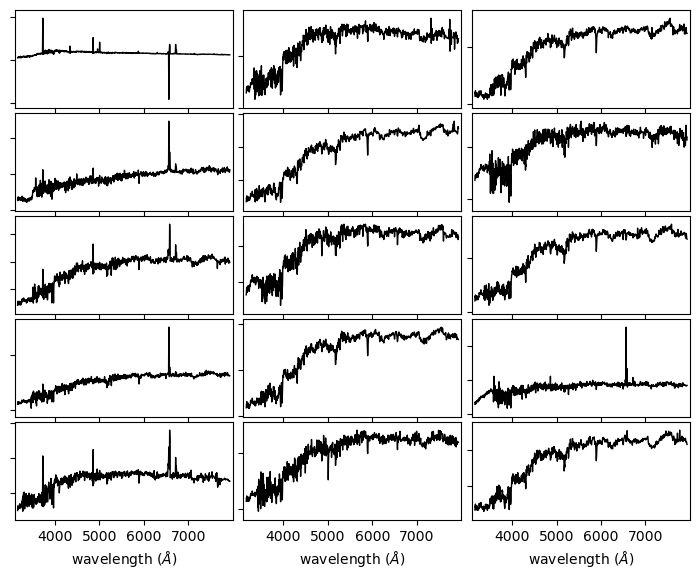

In [8]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
import numpy as np
from matplotlib import pyplot as plt
from astroML.datasets import sdss_corrected_spectra

#----------------------------------------------------------------------
# Use pre-computed PCA to reconstruct spectra
data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
spectra = sdss_corrected_spectra.reconstruct_spectra(data)
lam = sdss_corrected_spectra.compute_wavelengths(data)

#------------------------------------------------------------
# select random spectra
np.random.seed(5)
nrows = 5
ncols = 3
ind = np.random.randint(spectra.shape[0], size=nrows * ncols)
spec_sample = spectra[ind]

#----------------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(7.5, 6))

fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                    bottom=0.1, top=0.95, hspace=0.05)

for i in range(ncols):
    for j in range(nrows):
        ax = fig.add_subplot(nrows, ncols, ncols * j + 1 + i)
        ax.plot(lam, spec_sample[ncols * j + i], '-k', lw=1)
        ax.set_xlim(3100, 7999)

        ax.yaxis.set_major_formatter(plt.NullFormatter())
        ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
        if j < nrows - 1:
            ax.xaxis.set_major_formatter(plt.NullFormatter())
        else:
            plt.xlabel(r'wavelength $(\AA)$')

        ylim = ax.get_ylim()
        dy = 0.05 * (ylim[1] - ylim[0])
        ax.set_ylim(ylim[0] - dy, ylim[1] + dy)

plt.show()

At first glance, spectra may not seem like high-dimensional objects that need their dimensionality reduced. A spectrum has a specific flux measurement $F_\lambda$ in many pixels at different wavelengths $\lambda$. In our case, we have spectra that have 1000 pixels spanning the wavelength range 3200-7800 Angstroms. So we can think of each spectrum as really being a vector of 1000 flux measurements, and so occupying a 1000-D space. That is, our spectra have 1000 features, each of which is a specific flux at some wavelength.

If we imagine two galaxies with the same physical properties but at different distances from Earth, the farther one will be fainter just because of its greater distance. We want our PCA to treat two such galaxies as being the same, so we already normalized the spectra to have the same sum over pixels (approximately $F = \int F_\lambda d\lambda$). Thus, any differences in the spectra will come from the shape of the spectra, not the overall flux. Doing data preprocessing like this can make PCA more informative. Another common procedure is **data whitening**: dividing each feature by its standard deviation so that the feature values are comparable (the features may be in different units, let alone different orders of magnitude!).

`scikit-learn` makes it easy to perform PCA!

In [9]:
spectra.shape

(4000, 1000)

In [10]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(spectra)

PCA()

Remember that before doing PCA, we have to make sure the mean of each feature is zero (`scikit-learn` does this automatically). In this case, we subtract the average, over all spectra, of the specific flux at each wavelength, which we can think of as an average spectrum:

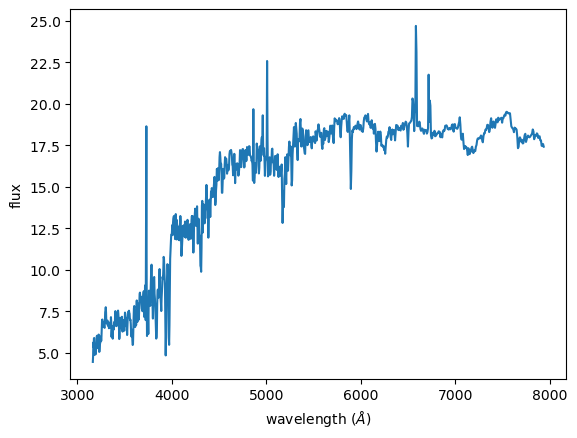

In [11]:
plt.plot(lam, spectra.mean(axis=0))
plt.xlabel(r'wavelength $(\AA)$')
plt.ylabel('flux')
plt.show()

This spectrum looks like a normal, mostly-red galaxy with a little bit of star formation occurring.

PCA gives us principal components, which are vectors in 1000-D feature space. Each feature is a specific flux at some wavelength, so we can interpret the principal components as spectra (often called *eigenspectra*). Let's look at the first four:

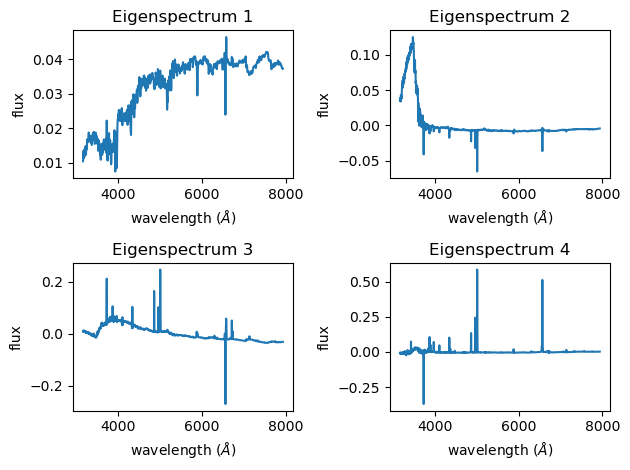

In [12]:
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title('Eigenspectrum %i' % (i+1))
    plt.plot(lam, pca.components_[i])
    plt.xlabel(r'wavelength $(\AA)$')
    plt.ylabel('flux')
plt.tight_layout()
plt.show()

These spectra can be (somewhat) interpreted physically - for example, adding the first eigenspectrum adds more red continuum, but reduces the relative strength of the Balmer $\alpha$ line at 6563 Angstroms. Thus, adding the first eigenspectrum corresponds to reducing the star formation activity of the galaxy. This sort of interpretation gets hard beyond the first few principal components.

We can investigate how much each component contributes to explaining the variance in our dataset (the **scree plot**):

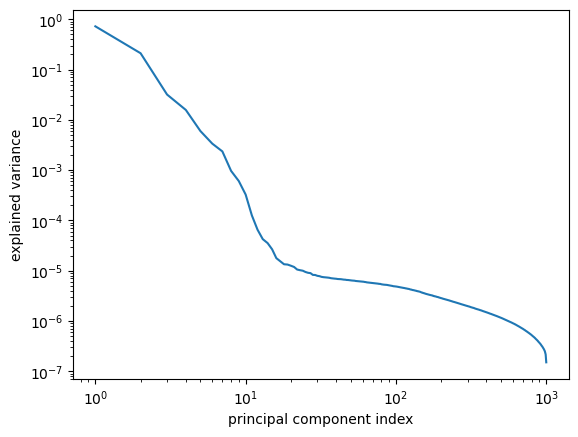

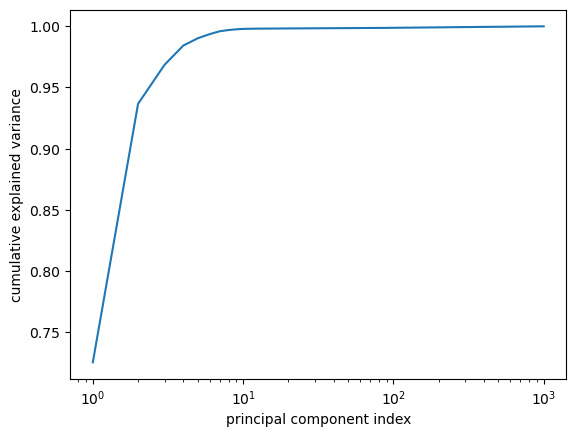

In [13]:
n_components = pca.components_.shape[0]

plt.plot(range(1, n_components+1), pca.explained_variance_ratio_)
plt.xlabel('principal component index')
plt.ylabel('explained variance')
plt.yscale('log')
plt.xscale('log')
plt.show()

plt.plot(range(1, n_components+1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('principal component index')
plt.ylabel('cumulative explained variance')
plt.xscale('log')
plt.show()

We can see that the first three components are the most important, explaining 73%, 21% and 3% of the variance in the dataset, respectively, and the variance explained by the next component falls off quickly with the number of principal components.

We can transform our data into the PCA basis, and then reduce the dimensionality by keeping only the first few principal components. There are many ways to choosing a number of principal components to use. One way is to look for a knee in the scree plot. Another is to pick a fraction of the variance we want explained (like 95%).

Let's see how much information our dimensionality reduction preserves by comparing one of the spectra with its projection onto the PCA components:

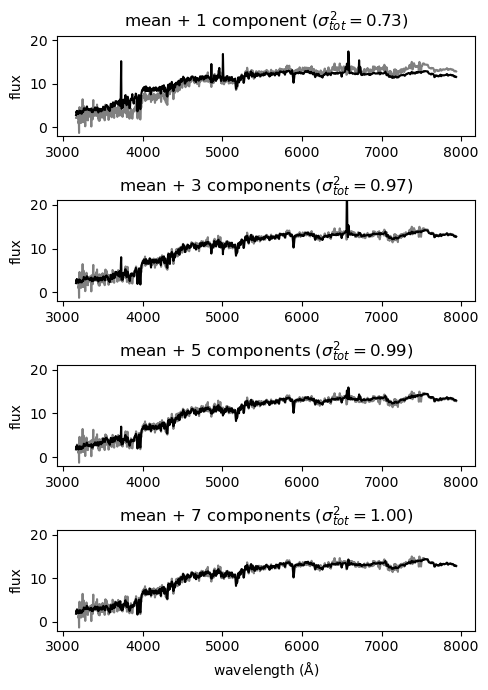

In [14]:
#------------------------------------------------------------
# Plot the sequence of reconstructions
fig = plt.figure(figsize=(5, 7))

for i, n in enumerate([1, 3, 5, 7]):
    plt.subplot(411 + i)
    
    
    plt.plot(lam, spectra[1], '-', c='gray') # plot original spectrum
    
    # do PCA on entire dataset, using only n components
    pca = PCA(n_components = n)
    pca.fit(spectra)
    # PCA projection coefficients
    coeff = pca.transform(spectra)
    # use projection coefficients to reconstruct spectrum
    recon = pca.inverse_transform(coeff)
    
    plt.plot(lam, recon[1], '-k')

    plt.ylim(-2, 21)
    plt.ylabel('flux')
    if i == 3:
        plt.xlabel(r'${\rm wavelength\ (\AA)}$')

    if n == 0:
        text = "mean"
    elif n == 1:
        text = "mean + 1 component "
        text += r"$(\sigma^2_{tot} = %.2f)$" % np.cumsum(pca.explained_variance_ratio_)[n - 1]
    else:
        text = "mean + %i components " % n
        text += r"$(\sigma^2_{tot} = %.2f)$" % np.cumsum(pca.explained_variance_ratio_)[n - 1]

    plt.title(text)
plt.tight_layout()
plt.show()

With more components, the projection (in black) gets closer to the original data (in grey). Measurement noise contributes more to the higher order principal components, so projecting onto the first 7 seems to clean up the spectrum pretty well. However, also notice while it only takes 3 components to get the continuum right, it takes 7 to get the lack of emission lines. PCA minimizes the sum of squared differences over pixels, so removing spectral lines that only cover a few pixels are not prioritized over getting the continuum right over many pixels.

Parts of spectra that are not well described as a linear combination of eigenspectra, like broad spectral lines of varying widths, will also not be well described by the first few PCA components. Over 30 eigenspectra are needed to adequately reproduce the spectra of broad-line quasars.